# Overcommeted to Hell
>  This Notebook is intended for me to practice my Time-Series ML. It got a bit messy because the main focus was really just the data preprocessing. Other than that, I wasn't to concerned with the end result

In [130]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [149]:
def load_data():
    events = pd.read_csv('data/holidays_events.csv')
    oil = pd.read_csv('data/oil.csv')
    stores = pd.read_csv('data/stores.csv')
    transactions = pd.read_csv('data/transactions.csv')

    # Make all date columns consistently datetime64[ns]
    for df, col in [
        (events, "date"),
        (oil, "date"),
        (transactions, "date")
    ]:
        df[col] = pd.to_datetime(df[col])

    return events, oil, stores, transactions

def feature_engineer_date(df: pd.DataFrame) -> pd.DataFrame:
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["dayofweek"] = df["date"].dt.dayofweek
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    return df

def merge_all(df: pd.DataFrame) -> pd.DataFrame:
    events, oil, stores, transactions = load_data()
    events = events.rename(columns={"type": "event_type"})

    event_cols = ["locale", "description", "locale_name", "transferred", "event_type"]
    store_cols = ["city", "state", "type", "cluster"]
    trans_cols = ["transactions"]

    # 1) stores
    drop_cols = [c for c in store_cols if c in df.columns]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    df = df.merge(stores, on="store_nbr", how="left")

    # 2) events
    drop_cols = [c for c in event_cols if c in df.columns]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    df = df.merge(events, on="date", how="left")

    # 3) oil — drop any previous dcoilwtico-like columns to avoid suffixes
    drop_cols = [c for c in df.columns if c.startswith("dcoilwtico")]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    df = df.merge(oil, on="date", how="left")

    # 4) transactions
    drop_cols = [c for c in trans_cols if c in df.columns]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    df = df.merge(transactions, on=["date", "store_nbr"], how="left")

    return df


In [132]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

for df, col in [
    (train, "date"),
    (test, "date")
]:
    df[col] = pd.to_datetime(df[col])

# Less than 1% of the dataset is NA
train = train.dropna(subset=["date"])
train = merge_all(train)
train = feature_engineer_date(train)

# Select columns excluding numeric types
non_numeric_cols = train.select_dtypes(exclude=[np.number])

# Get the list of column names
non_numeric_features = non_numeric_cols.columns.tolist()

print("DataFrame columns:")
print(train.dtypes)
print("\nNon-numeric features:")
print(non_numeric_features)

DataFrame columns:
id                       int64
date            datetime64[ns]
store_nbr                int64
family                  object
sales                  float64
onpromotion              int64
city                    object
state                   object
type                    object
cluster                  int64
event_type              object
locale                  object
locale_name             object
description             object
transferred             object
dcoilwtico             float64
transactions           float64
year                     int32
month                    int32
dayofweek                int32
weekofyear               int64
is_weekend               int64
dtype: object

Non-numeric features:
['date', 'family', 'city', 'state', 'type', 'event_type', 'locale', 'locale_name', 'description', 'transferred']


In [129]:
# 1) Lags and rolling features
train = train.sort_values(by=["store_nbr", "family", "date"]).reset_index(drop=True)
group_cols = ["store_nbr", "family"]  # per store-family series

train["sales_lag_1"] = train.groupby(group_cols)["sales"].shift(1)
train["sales_lag_7"] = train.groupby(group_cols)["sales"].shift(7)
train["sales_lag_14"] = train.groupby(group_cols)["sales"].shift(14)
train["sales_lag_28"] = train.groupby(group_cols)["sales"].shift(28)

train["sales_roll_7"] = train.groupby(group_cols)["sales"].shift(1).rolling(7).mean()
train["sales_roll_14"] = train.groupby(group_cols)["sales"].shift(1).rolling(14).mean()
train["sales_roll_28"] = train.groupby(group_cols)["sales"].shift(1).rolling(28).mean()

train = train.dropna(subset=["sales_lag_28", "sales_roll_28"]).reset_index(drop=True)

# 2) Sort by date for time-based split
train = train.sort_values("date").reset_index(drop=True)

# 3) Features / target
X = train.drop(columns=["sales", "id", "date"])
y = np.log1p(train["sales"])

# 4) Time-based validation split
n_val = int(len(train) * 0.1)
X_train, X_valid = X.iloc[:-n_val], X.iloc[-n_val:]
y_train, y_valid = y.iloc[:-n_val], y.iloc[-n_val:]

# 5) Categorical columns: make them strings and handle NaN
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

X_train = X_train.copy()
X_valid = X_valid.copy()

for col in cat_cols:
    X_train.loc[:, col] = X_train[col].astype("string").fillna("NA")
    X_valid.loc[:, col] = X_valid[col].astype("string").fillna("NA")

cat_feature_indices = [X.columns.get_loc(c) for c in cat_cols]

# 6) Model
model = CatBoostRegressor(
    loss_function="RMSE",
    depth=6,
    learning_rate=0.1,
    iterations=400,
    verbose=100
)


In [133]:
model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    cat_features=cat_feature_indices,
    early_stopping_rounds=200
)

y_pred = np.expm1(model.predict(X_valid))
rmse = np.sqrt(((y_pred - train["sales"].iloc[-n_val:]) ** 2).mean())
print("Validation RMSE:", rmse)


0:	learn: 2.4499063	test: 2.3840585	best: 2.3840585 (0)	total: 3.49s	remaining: 23m 10s
100:	learn: 0.4196014	test: 0.4223365	best: 0.4223365 (100)	total: 3m 43s	remaining: 11m 2s
200:	learn: 0.4035997	test: 0.4137453	best: 0.4137453 (200)	total: 8m 3s	remaining: 7m 58s
300:	learn: 0.3947361	test: 0.4084126	best: 0.4084126 (300)	total: 13m 1s	remaining: 4m 17s
399:	learn: 0.3890769	test: 0.4054815	best: 0.4054815 (399)	total: 17m 33s	remaining: 0us

bestTest = 0.405481532
bestIteration = 399

Validation RMSE: 1863.7962489159531


In [156]:
test = merge_all(test)
test = feature_engineer_date(test)

missing = [c for c in X.columns if c not in test.columns]
for c in missing:
    test[c] = np.nan

X_test = test[X.columns]

X_test = X_test.copy()
for col in cat_cols:
    X_test[col] = X_test[col].astype("string").fillna("NA")

test_pred_log = model.predict(X_test)
test_pred = np.expm1(test_pred_log)

submission = pd.DataFrame({
    "id": test["id"].values,
    "sales": test_pred
})

os.makedirs("submissions/untuned_cat", exist_ok=True)
submission.to_csv("submissions/untuned_cat/submission.csv", index=False)



I've done a lot of work with tabular data so the purpose of this competition was just to get use to rolling windows. I ran into some errors that made me jump around hoops in order to not retrain my catboost model. Anyways, this was a great learning experience.

<Axes: >

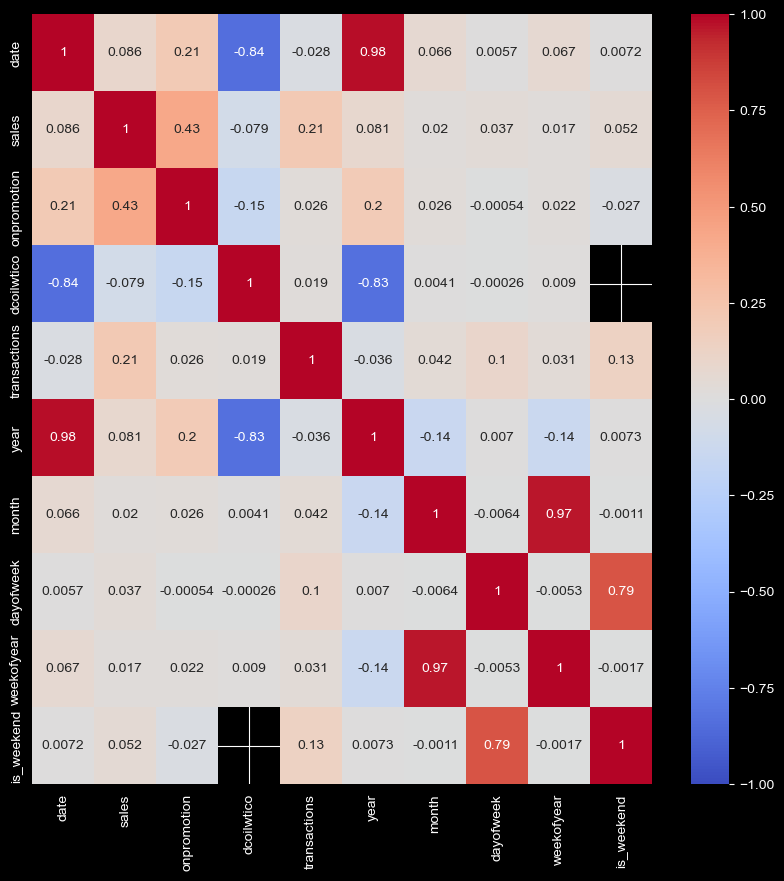

In [166]:
numeric_cols_df = train.select_dtypes(include=[np.number, np.datetime64, np.floating])
numeric_cols_df = numeric_cols_df.drop(columns=['id', 'store_nbr', 'cluster'])

coor_matrix = numeric_cols_df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(coor_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)